<a href="https://www.kaggle.com/code/ibrahimnibrahim/malaria-detection-97-test-accuracy?scriptVersionId=244280938" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# import the libraries

In [1]:
import tensorflow as tf

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras import layers, models
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import roc_curve, auc

2025-06-07 21:10:33.685362: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1749330633.869142      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1749330633.932849      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# Set the Files and Create Datasets

## Assign files to variables

In [2]:
TRAIN_FILE='/kaggle/input/malaria-detection/Malaria Dataset/train'
TEST_FILE='/kaggle/input/malaria-detection/Malaria Dataset/test'
VALID_FILE='/kaggle/input/malaria-detection/Malaria Dataset/valid'

## Create Datasets for train, test and validation

In [3]:

train_dataset = tf.keras.utils.image_dataset_from_directory(
    directory=TRAIN_FILE, 
    labels='inferred',              
    label_mode='binary',        
    image_size=(224, 224),            
    batch_size=64                    
)

test_dataset = tf.keras.utils.image_dataset_from_directory(
    directory=TEST_FILE, 
    labels='inferred',              
    label_mode='binary',        
    image_size=(224, 224),            
    batch_size=64                    
)

valid_dataset = tf.keras.utils.image_dataset_from_directory(
    directory=VALID_FILE, 
    labels='inferred',              
    label_mode='binary',        
    image_size=(224, 224),            
    batch_size=64                    
)

Found 13152 files belonging to 2 classes.


I0000 00:00:1749330671.774199      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


Found 626 files belonging to 2 classes.
Found 1253 files belonging to 2 classes.


In [4]:
train_dataset=train_dataset.cache().prefetch(buffer_size=tf.data.AUTOTUNE).shuffle(buffer_size=1000)
test_dataset=test_dataset.cache().prefetch(buffer_size=tf.data.AUTOTUNE)
valid_dataset=valid_dataset.cache().prefetch(buffer_size=tf.data.AUTOTUNE)

# NN architecture

## EfficientNetB0 & Data augmentation layers

In [5]:
base_model = EfficientNetB0(
    weights='imagenet',  
    input_shape=(224, 224, 3),
    include_top=False    
)

data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.1),
    layers.RandomContrast(0.1),
    layers.RandomTranslation(0.1, 0.1),
])



inputs = layers.Input(shape=(224, 224, 3))
x = data_augmentation(inputs)            # 1. Augment
# x = preprocess_input(x)                   # 2. Preprocess
x = base_model(x, training=False)          # 3. Pass through base_model
x = layers.GlobalAveragePooling2D()(x)     # 4. Pool output
x = layers.Dense(512, activation='relu')(x)  # 5. Dense Layer
x = layers.Dense(1, activation='sigmoid')(x) # 6. Output Layer for binary classification

final_model = models.Model(inputs=inputs, outputs=x)

final_model.summary()

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential (Sequential)              │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ efficientnetb0 (Functional)          │ (None, 7, 7, 1280)          │       4,049,571 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │         655,872 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │             513 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,705,956 (17.95 MB)

 Trainable params: 4,663,933 (17.79 MB)

 Non-trainable params: 42,023 (164.16 KB)

In [6]:
final_model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-3),  
    loss='binary_crossentropy',
    metrics=['accuracy']
)

## Set some callbacks

In [7]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', 
    patience=5,  
    restore_best_weights=True
)

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss', 
    factor=0.1, 
    patience=3, 
    min_lr=1e-7
)

## Train the model

In [8]:
history = final_model.fit(
    train_dataset,
    validation_data=valid_dataset,
    epochs=100,
    callbacks=[early_stopping, reduce_lr]
)

Epoch 1/100


E0000 00:00:1749330728.843197      19 meta_optimizer.cc:966] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inStatefulPartitionedCall/functional_1_1/efficientnetb0_1/block2b_drop_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
I0000 00:00:1749330757.679149      63 cuda_dnn.cc:529] Loaded cuDNN version 90300


206/206 ━━━━━━━━━━━━━━━━━━━━ 188s 515ms/step - accuracy: 0.8945 - loss: 0.2546 - val_accuracy: 0.9354 - val_loss: 0.1785 - learning_rate: 0.0010
Epoch 2/100
206/206 ━━━━━━━━━━━━━━━━━━━━ 97s 469ms/step - accuracy: 0.9481 - loss: 0.1520 - val_accuracy: 0.9409 - val_loss: 0.1533 - learning_rate: 0.0010
Epoch 3/100
206/206 ━━━━━━━━━━━━━━━━━━━━ 97s 469ms/step - accuracy: 0.9564 - loss: 0.1309 - val_accuracy: 0.9593 - val_loss: 0.1386 - learning_rate: 0.0010
Epoch 4/100
206/206 ━━━━━━━━━━━━━━━━━━━━ 97s 472ms/step - accuracy: 0.9580 - loss: 0.1211 - val_accuracy: 0.9689 - val_loss: 0.0870 - learning_rate: 0.0010
Epoch 5/100
206/206 ━━━━━━━━━━━━━━━━━━━━ 96s 467ms/step - accuracy: 0.9557 - loss: 0.1186 - val_accuracy: 0.9577 - val_loss: 0.1050 - learning_rate: 0.0010
Epoch 6/100
206/206 ━━━━━━━━━━━━━━━━━━━━ 97s 471ms/step - accuracy: 0.9620 - loss: 0.1066 - val_accuracy: 0.9577 - val_loss: 0.1224 - learning_rate: 0.0010
Epoch 7/100
206/206 ━━━━━━━━━━━━━━━━━━━━ 97s 471ms/step - accuracy: 0.9644 

# Model Evaluate

## Classification report for Validation Dataset

In [9]:
y_pred_probs = final_model.predict(valid_dataset)
y_pred = np.where(y_pred_probs > 0.5, 1, 0)  


y_true = np.concatenate([y for x, y in valid_dataset], axis=0)
print(classification_report(y_true, y_pred))


20/20 ━━━━━━━━━━━━━━━━━━━━ 7s 215ms/step
              precision    recall  f1-score   support

         0.0       0.98      0.97      0.97       629
         1.0       0.97      0.98      0.97       624

    accuracy                           0.97      1253
   macro avg       0.97      0.97      0.97      1253
weighted avg       0.97      0.97      0.97      1253



## Confusion matrix for Validation Dataset

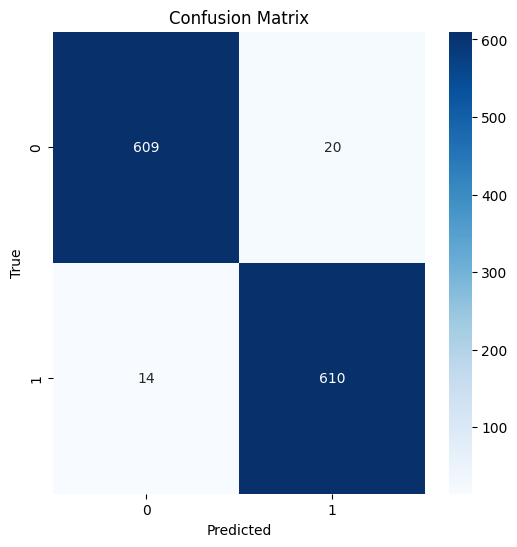

In [10]:
cm = confusion_matrix(y_true, y_pred)

# 5. Plot it nicely
plt.figure(figsize=(6,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

## Classification report for test Dataset

In [11]:
y_pred_probs = final_model.predict(test_dataset)
y_pred = np.where(y_pred_probs > 0.5, 1, 0)  


y_true = np.concatenate([y for x, y in test_dataset], axis=0)
print(classification_report(y_true, y_pred))

10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 164ms/step
              precision    recall  f1-score   support

         0.0       0.96      0.95      0.96       309
         1.0       0.95      0.97      0.96       317

    accuracy                           0.96       626
   macro avg       0.96      0.96      0.96       626
weighted avg       0.96      0.96      0.96       626



## Confusion matrix for test Dataset

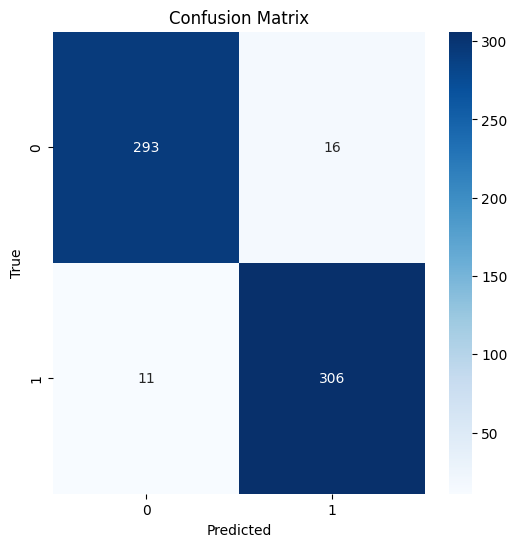

In [12]:
cm = confusion_matrix(y_true, y_pred)

# 5. Plot it nicely
plt.figure(figsize=(6,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

## plot the History

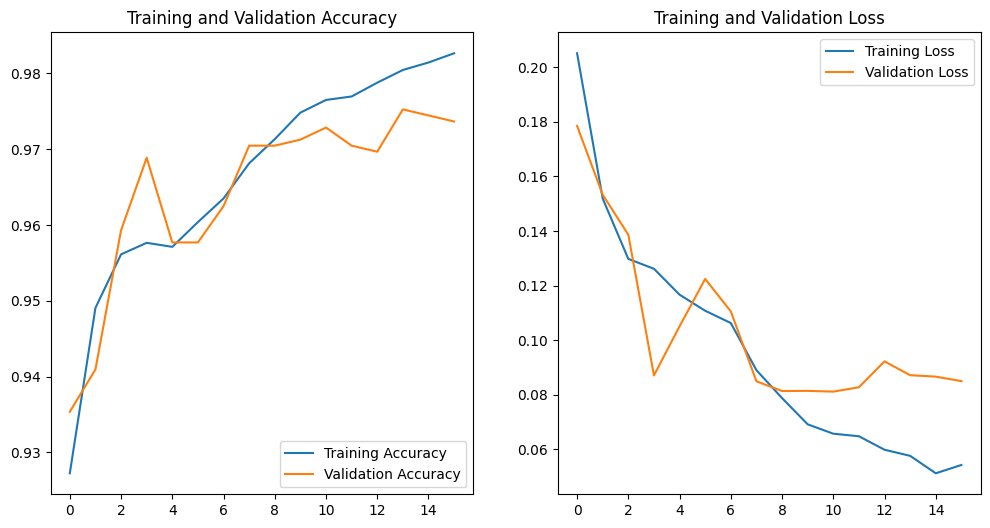

In [13]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(len(acc))

# 2. Plot it
plt.figure(figsize=(12, 6))

# Accuracy Plot
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

# Loss Plot
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

plt.show()

## ROC & AUC

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step


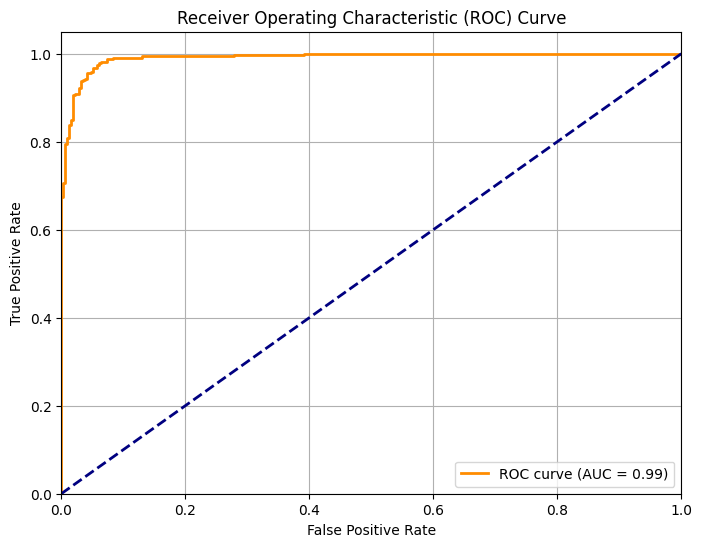

In [14]:
# 1. Get true labels and predicted probabilities
y_true = np.concatenate([y for x, y in test_dataset], axis=0)
y_pred_probs = final_model.predict(test_dataset).ravel()  # flatten probs to shape (num_samples,)

# 2. Compute ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_true, y_pred_probs)
roc_auc = auc(fpr, tpr)

# 3. Plot it
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')  # Random chance line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.grid()
plt.show()

20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step


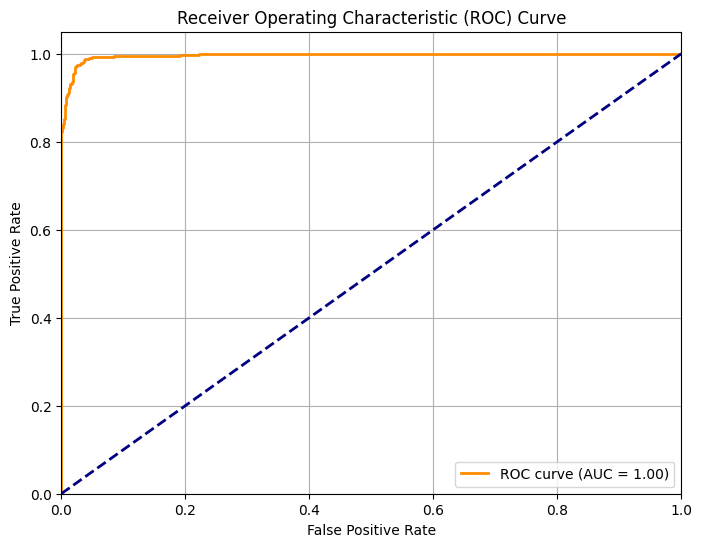

In [15]:
# 1. Get true labels and predicted probabilities
y_true = np.concatenate([y for x, y in valid_dataset], axis=0)
y_pred_probs = final_model.predict(valid_dataset).ravel()  # flatten probs to shape (num_samples,)

# 2. Compute ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_true, y_pred_probs)
roc_auc = auc(fpr, tpr)

# 3. Plot it
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')  # Random chance line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.grid()
plt.show()

# Plot some images

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


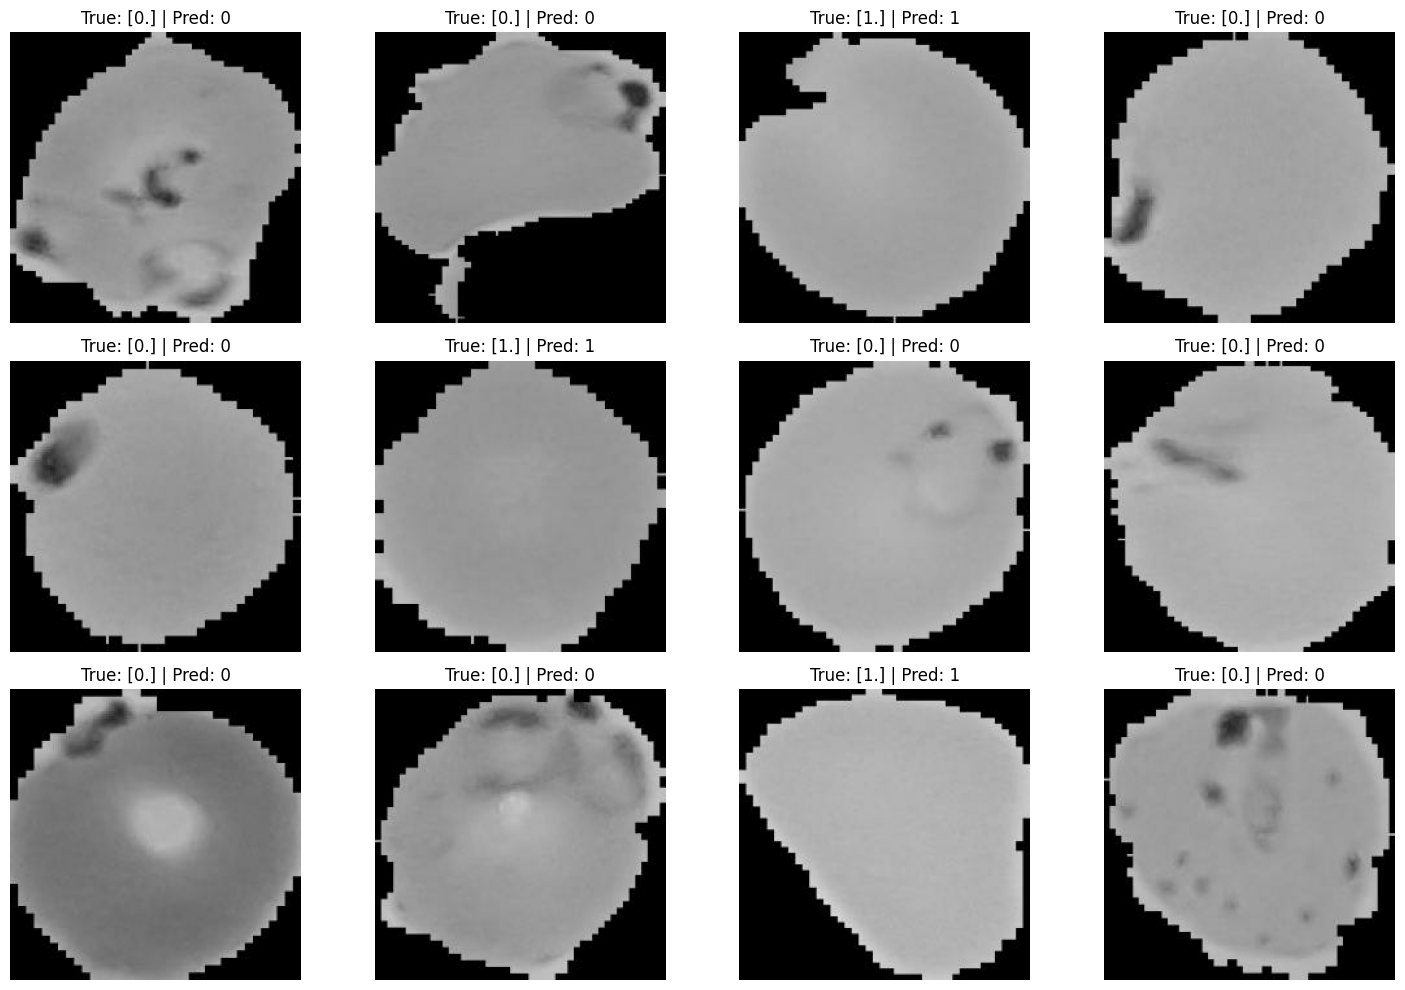

In [16]:
import matplotlib.pyplot as plt
import numpy as np

# 1. Unbatch your test dataset (if not already)
test_ds_unbatched = test_dataset.unbatch()

# 2. Take a few samples
sample_images = []
sample_labels = []

for image, label in test_ds_unbatched.take(12):  # Take 12 examples
    sample_images.append(image.numpy())
    sample_labels.append(label.numpy())

sample_images = np.array(sample_images)
sample_labels = np.array(sample_labels)

# 3. Predict on sample images
pred_probs = final_model.predict(sample_images)
pred_labels = (pred_probs > 0.5).astype(int).flatten()

# 4. Plot
plt.figure(figsize=(15, 10))

for i in range(len(sample_images)):
    plt.subplot(3, 4, i + 1)
    plt.imshow(sample_images[i].astype("uint8"))  # undo normalization if needed
    plt.title(f"True: {sample_labels[i]} | Pred: {pred_labels[i]}")
    plt.axis('off')

plt.tight_layout()
plt.show()